# EfficientNetV2 with Fashion-MNIST Benchmark

### SOTA Model and Training Procedure

Author : Wong Zhao Wu

# Abstract

Improving the performance of a vision model is product of the following three different sections [(Cited from Revisiting ResNets)](https://arxiv.org/pdf/2103.07579.pdf).

1. Model architecture
2. Training Procedure
3. Scaling Method _(Not Enough Computation Power to Explore)_

In CA1, the goal is to implement state of the art model architecture, training procudure and dataset augmentation without compromising the generalisation capability and performance of the model.

To achieve the goal, I have make use of the [EfficientNetV2 (Tan, M., & Le, Q. V., 2021)](https://arxiv.org/abs/2104.00298) model family that has achieve that has achieved 99% accuracy and comparable to other ViT models from [paperswithcode CIFAR-10 Benchmark Leaderboard](https://paperswithcode.com/sota/image-classification-on-cifar-10). EfficientNetV2 is a Convolutional Network Family that is production of Neural architecture Search (NAS) with implementations of latest modelling techniques like Fused-MBConv Net from [MobileNetV2 Paper (Sandler. etgi al, 2018)](https://arxiv.org/abs/1801.04381v4) with [Squeeze-and-Excitation (Hu et al., 2018)](https://arxiv.org/abs/1709.01507).

As for the training procedure, I have gain inspiration from the EfficientNetV2 paper to introduce **Progressive Learning** to scale the input image resolution _([Progressive Resizing](https://www.bookstack.cn/read/th-fastai-book/spilt.3.798d5ac22392691a.md))_ and regularization _([RandAugment](https://arxiv.org/abs/1909.13719), [Dropout](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/), [Stochastic Depth](https://arxiv.org/abs/1603.09382), L2 Regularization)_ progressively to speed up the training without causing accuracy drop. 

Although I did not managed to achieve the same performance as the leaderboard with proper training-validation-test split convention, I managed to achieve accuracy of 93.93% on 10,000 test set and gain practical experience in training and building model in Pytorch.


# Notebook Initialization

If you are running this notebook on Google Colab, you need to clone the private working repository and install git-lfs to gain access to trained weights for the model.



## Clone Working Repo

> If you are running this notebook on Local Instance, you can skip the following steps to clone the repo.

Before cloning the repository, you need to first install `git-lfs` on Google-Colab to pull the weights stored in the repo. The next two cell will complete the job for you.


In [1]:
# Clone Repo for Dataset
!git clone https://github.com/kiritowu/Deep-Learning.git
%cd Deep-Learning/CV/EfficientNetV2-with-Image-Classification-Benchmarks

Detected operating system as Ubuntu/bionic.
Checking for curl...
Detected curl...
Checking for gpg...
Detected gpg...
Running apt-get update... done.
Installing apt-transport-https... done.
Installing /etc/apt/sources.list.d/github_git-lfs.list...done.
Importing packagecloud gpg key... done.
Running apt-get update... done.

The repository is setup! You can now install packages.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 6,526 kB of archives.
After this operation, 14.7 MB of additional disk space will be used.
Get:1 https://packagecloud.io/github/git-lfs/ubuntu bionic/main amd64 git-lfs amd64 3.0.2 [6,526 kB]
Fetched 6,526 kB in 0s (16.9 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

## Import Modules & Define Global Variables

Before importing any of the modules, we need to make sure the packages are up to date.

Since the packages on Google Colab is outdated, we need to manually Upgrade the packages to get the cells running.

Other than the raw Pytorch packages family _(e.g. torch, torchvision)_, I have installed two extra packages namely,

1. [timm](https://github.com/rwightman/pytorch-image-models)

   Deep-learning library created by Ross Wightman and is a collection of SOTA computer vision models, layers, utilities, optimizers, schedulers, data-loaders, augmentations and also training/validating scripts with ability to reproduce ImageNet training results.

   > I have used the library to access Pytorch implementation of EfficientNetV2 which is only released officially on Tensorflow.


In [3]:
# Upgrade and Install packages
!pip install --upgrade timm torch torchvision

     |████████████████████████████████| 1.7 MB 7.1 MB/s 
     |████████████████████████████████| 376 kB 71.4 MB/s 
     |████████████████████████████████| 97 kB 8.7 MB/s 
     |████████████████████████████████| 140 kB 71.0 MB/s 
     |████████████████████████████████| 180 kB 52.2 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=e9e97f8e6d4ae15218407b73435ec65fef5b31c9476c93288de253d5c620ca49
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=9ee258de2c4efbd897a420ebfe6fa48175a09815851ebf20e92592bc44a2fa01
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [1]:
# ----------------------------Import Modules------------------------------ #
import os
import sys
import time
import timm
import torch
import utils
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, SubsetRandomSampler

# ----------------------------Env Variables-------------------------------- #
# Set small batch size to prevent overloading the RAM with high resolution pictures (Progressive Learning)
BATCH_SIZE = 256
# Number of CPU threads for number of worker
CPU_COUNT = os.cpu_count() 
# Check if notebook is running on Google
BASE_FOLDER = "/content/DELE-Temp-CA/CA1/CNN-FashionMNIST/" if 'google.colab' in sys.modules else '.'  
# Change folder
os.chdir(BASE_FOLDER)
print("Base Folder : {}".format(BASE_FOLDER))

Base Folder : /content/DELE-Temp-CA/CA1/CNN-FashionMNIST/


## Checking GPU

To load the model, you need to first enable GPU runtime on Google Colab through "Runtime >> Change runtime type >> Hardware accelerator >> GPU".

Since I am using Colab-Pro subscription service, I am able to gain access to Tesla P-100. However, for a normal Colab user, you are normally assigned with Tesla K-80.

If you are running into trouble of not enough memory to run model, try to reduce the batch size.


In [3]:
# Check if Cuda GPU is available and Pytorch version
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Pytorch is currently using {device}")
# Check pytorch version 
assert torch.__version__ > '1.10.0', "Pytorch version is outdated, Please upgrade Pytorch to v1.10.0 or above"

Pytorch is currently using cuda


## Fix Global Random Seeds

Since I am running the experiments on different machines across multiple runs, I will set a fixed global random-state better evaluate the performance of the model in a more consistent manner. _(i.e. Data Splitting and Weights initializing will remain the same for every runs)_


In [4]:
# Set random seed for reproducibility
torch.manual_seed(7)
np.random.seed(7)

# Dataset Preparation


## Data Augmentation

For data augmentation, I utilises [RandAugment](https://arxiv.org/abs/1909.13719) which contains of sets of basic data augmentation techniques/policies. _(e.g. Identity, ShearX, ShearY, TranslateX, TranslateY, Rotate, Brightness, Color, Contrast, Sharpness, Posterize, Solarize, AutoContrast and Equalize)_

The reason of choosing RandAugment is the ability to tune the `magnitude` of augmentation policies in line with the notion of progressive training (i.e. start with smaller magnitude and increase it step-by-step)

Other than data augmentation, I have also performed `Resize` using torchvision package to progressively scale up the resolution of input image.

The following diagram shows the hyperparameters used on different epoch

| Epoch | Image Resolution | RandAugment |
| :---- | :--------------- | :---------- |
| 1-20  | 28              | 5          |
| 21-50 | 50              | 10          |
| 51-80 | 80              | 20          |


In [5]:
from torch import Tensor
from typing import Optional, List, Dict, Tuple
from torchvision.transforms import InterpolationMode
class singleChannelRandAugment(transforms.autoaugment.RandAugment):
    def __init__(   self, 
                    num_ops: int = 2, 
                    magnitude: int = 9, 
                    num_magnitude_bins: int = 31, 
                    is_single_channel: bool = True, # Configuration to Disable Color Based RandAugment Policies
                    interpolation: InterpolationMode = InterpolationMode.NEAREST, 
                    fill: Optional[List[float]] = None
                ) -> None:
        self.is_single_channel = is_single_channel
        super().__init__(num_ops=num_ops, magnitude=magnitude, num_magnitude_bins=num_magnitude_bins, interpolation=interpolation, fill=fill)
    
    def _augmentation_space(self, num_bins: int, image_size: List[int]) -> Dict[str, Tuple[Tensor, bool]]:
        if self.is_single_channel:
            return {
                # op_name: (magnitudes, signed)
                "Identity": (torch.tensor(0.0), False),
                "ShearX": (torch.linspace(0.0, 0.3, num_bins), True),
                "ShearY": (torch.linspace(0.0, 0.3, num_bins), True),
                "TranslateX": (torch.linspace(0.0, 150.0 / 331.0 * image_size[0], num_bins), True),
                "TranslateY": (torch.linspace(0.0, 150.0 / 331.0 * image_size[1], num_bins), True),
                "Rotate": (torch.linspace(0.0, 30.0, num_bins), True),
                "Brightness": (torch.linspace(0.0, 0.9, num_bins), True),
                #### Remove Policies with Image Color
                # "Color": (torch.linspace(0.0, 0.9, num_bins), True),
                # "Contrast": (torch.linspace(0.0, 0.9, num_bins), True),
                # "Sharpness": (torch.linspace(0.0, 0.9, num_bins), True),
                # "Posterize": (8 - (torch.arange(num_bins) / ((num_bins - 1) / 4)).round().int(), False),
                # "Solarize": (torch.linspace(255.0, 0.0, num_bins), False),
                # "AutoContrast": (torch.tensor(0.0), False),
                # "Equalize": (torch.tensor(0.0), False),
            }
        else:
            return {
                # op_name: (magnitudes, signed)
                "Identity": (torch.tensor(0.0), False),
                "ShearX": (torch.linspace(0.0, 0.3, num_bins), True),
                "ShearY": (torch.linspace(0.0, 0.3, num_bins), True),
                "TranslateX": (torch.linspace(0.0, 150.0 / 331.0 * image_size[0], num_bins), True),
                "TranslateY": (torch.linspace(0.0, 150.0 / 331.0 * image_size[1], num_bins), True),
                "Rotate": (torch.linspace(0.0, 30.0, num_bins), True),
                "Brightness": (torch.linspace(0.0, 0.9, num_bins), True),
                "Color": (torch.linspace(0.0, 0.9, num_bins), True),
                "Contrast": (torch.linspace(0.0, 0.9, num_bins), True),
                "Sharpness": (torch.linspace(0.0, 0.9, num_bins), True),
                "Posterize": (8 - (torch.arange(num_bins) / ((num_bins - 1) / 4)).round().int(), False),
                "Solarize": (torch.linspace(255.0, 0.0, num_bins), False),
                "AutoContrast": (torch.tensor(0.0), False),
                "Equalize": (torch.tensor(0.0), False),
            }
                


In [6]:
# Mean and Std of FashionMNIST dataset are calculated through the following code
# https://notebook.community/m2dsupsdlclass/lectures-labs/labs/08_frameworks/Fashion_MNIST_classification
# Value of Mean and Std are close to 0 as Torchvision returns dataset in range(0-1)
_FASHION_MEAN = (0.2856)
_FASHION_STD  = (0.3201)

rand_aug_train = transforms.Compose([
    transforms.Resize((80,80)),
    singleChannelRandAugment(magnitude = 20),
    transforms.ToTensor(), 
    transforms.Normalize(_FASHION_MEAN, _FASHION_STD),
])

rand_aug_test = transforms.Compose([
    transforms.Resize((80,80)),
    transforms.ToTensor(), 
    transforms.Normalize(_FASHION_MEAN, _FASHION_STD),
])

## Downloading Dataset

After creating the transform pipeline, I will now download the CIFAR10 dataset using built-in torchvision Classes.


In [7]:
#  Allow download with unverified SSL to escape from SSL error
import ssl
ssl._create_default_https_context = ssl._create_unverified_context 

# Downloading CIFAR10 Dataset
train_data = datasets.FashionMNIST(
                            root='./data', 
                            train=True, 
                            download=True, 
                            transform = rand_aug_train
                        )
test_data = datasets.FashionMNIST(
                            root='./data', 
                            train=False, 
                            download=True, 
                            transform = rand_aug_test
                        )

## Data Loader with Train-Dev-Test split

Finally, I have performed Train-Dev-Test split on the training and testing dataset before wraping into `DataLoader` class to generate an iterable data generator.


In [8]:
train_length = train_data.__len__() # Length training dataset
train_indices = np.arange(train_length) # Create arange 
np.random.shuffle(train_indices) # Randomly Suffle training indices

# Create Data Loader
train_loader = DataLoader(
                        train_data, 
                        batch_size=BATCH_SIZE, 
                        sampler = SubsetRandomSampler(train_indices[:int(train_length*0.8)]) # 80% of data in train set
                    )

val_loader = DataLoader(
                        train_data, 
                        batch_size=BATCH_SIZE, 
                        sampler = SubsetRandomSampler(train_indices[int(train_length*0.8):]) #20% of data in validation set
                    )

test_loader = DataLoader(
                        test_data, 
                        batch_size=BATCH_SIZE,
                    )

# Disable Data Augmentation on Validation Set
val_loader.dataset.transform = rand_aug_test
val_loader.dataset.transform

Compose(
    Resize(size=(80, 80), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=0.2856, std=0.3201)
)

# Basic EDA

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


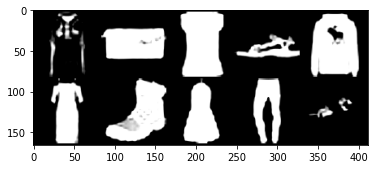

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


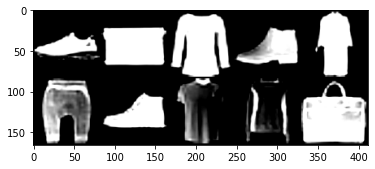

In [9]:
training_batch = next(iter(train_loader))
validation_batch = next(iter(val_loader))

train_img = torchvision.utils.make_grid(training_batch[0][:10], nrow=5)
plt.imshow(train_img.permute(1,2,0))
plt.show()

validation_img = torchvision.utils.make_grid(validation_batch[0][:10], nrow=5)
plt.imshow(validation_img.permute(1,2,0))
plt.show()

# Building the Model

To build the EfficientNetV2 model, instead of implementing every components from scratch _(i.e. assembling furniture from IKEA)_, I make used of [timm](https://github.com/rwightman/pytorch-image-models) Package that contains pre-built Pytorch implementation _(i.e. buy furniture built by expert and modify from there)_.

To be fair, I did not used any of the pre-trained weights but to start the traning from scratch to better experiment on Progressive Training.

The following function is able to obtain the model with the following modifications:

1. Implement Progressive Learning with Increasing Dropout and Stochastic Depth Rate
2. Replace the Fully-Connected Layer to only 10 neuron (Since there are only 10 classes in CIFAR-10)

The default model choosen is EfficientNetV2-M since that is the biggest model that a single P-100 and RTX3090 can support. _(Will explore on parallelism next time)_


In [10]:
def get_custom_efficientnetv2(model_scale = 's', training_phase = 's', in_chans=1):
    assert model_scale in ['s', 'm', 'l', 'xl'], "Please specify model_scale with alphabert 's', 'm', 'l', 'xl' only."
    assert training_phase in ['s', 'm', 'l'], "Please specify Progressive training phase with alphabert 's', 'm', 'l' only."

    # Model Size
    if training_phase == 's':
        model_kwargs = dict(drop_rate=0.2, drop_path_rate=0, in_chans = in_chans)
    elif training_phase == 'm':
        model_kwargs = dict(drop_rate=0.3, drop_path_rate=0.1, in_chans = in_chans)
    elif training_phase == 'l':
        model_kwargs = dict(drop_rate=0.4, drop_path_rate=0.2, in_chans = in_chans)

    # Import Model Architecture
    model = timm.create_model(f"efficientnetv2_{model_scale}", **model_kwargs)
    model.classifier = nn.Sequential(
        nn.Linear(in_features = 1280, out_features = 10) # Final layer with 10 classes
    )
    return model

In [19]:
model = get_custom_efficientnetv2(training_phase='s') # Import model
model.to(device) # Move model to the right device

EfficientNet(
  (conv_stem): Conv2d(1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
      )
      (1): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
      )
    )
    (1): Sequential(
      (0): EdgeResidual(
        (conv_exp): Conv2d(24, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, trac

# Training Model

The following cells contains code to train the model. Do run all Training & Validation Utilities and Criterions to carry out training and inference smoothly.


## Training and Validation Utilities

The following codes are direct reference from [HabanaAI/Model-Reference](https://github.com/HabanaAI/Model-References/blob/master/PyTorch/computer_vision/ImageClassification/ResNet/train.py) training script with comments & modifications to better display the training and evaluation process.


In [14]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        #pdb.set_trace()
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)

        pred = pred.t()
        pred_cpu = torch.tensor(pred, device='cpu')
        target_cpu = torch.tensor(target, device='cpu')

        correct = pred_cpu.eq(target_cpu[None])

        res = []
        for k in topk:
            correct_k = correct[:k].flatten().sum(dtype=torch.float32)
            res.append(correct_k * (100.0 / batch_size))
        return res

In [15]:
def train_one_epoch(model:nn.Module, 
                    criterion:nn.CrossEntropyLoss, 
                    optimizer, 
                    data_loader:torch.utils.data.DataLoader, 
                    device:str, 
                    epoch:int, 
                    print_freq:int, 
                    apex=False, 
                    warmup=True) -> None:
    
    # Set training mode
    model.train() 
    # Logging Utils
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.8f}'))
    metric_logger.add_meter('img/s', utils.SmoothedValue(window_size=10, fmt='{value:.0f}'))

    header = 'Epoch: [{}]'.format(epoch)
    step_count = 0
    last_print_time= time.time()

    # Early Warm-Up
    warmup_lr_scheduler = None
    if epoch == 0 and warmup:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)
        warmup_lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    # Traing Loop
    for image, target in metric_logger.log_every(data_loader, print_freq, header):
        image, target = image.to(device), target.to(device) # Move image and target to GPU if possible

        dl_ex_start_time=time.time()

        output = model(image) # Forward Prop
        loss = criterion(output, target) # Calculate Loss
        optimizer.zero_grad() # Clear previous gradients

        loss.backward() # Calculate gradient to the loss

        optimizer.step() # Gradient descent step

        if warmup_lr_scheduler is not None:
            warmup_lr_scheduler.step() # Update Learning Rate if Warmup

        if step_count % print_freq == 0: # Print training log
            output_cpu = output.detach().to('cpu')
            acc1, acc5 = accuracy(output_cpu, target, topk=(1, 5))
            batch_size = image.shape[0]
            metric_logger.update(loss=loss.item(), lr=optimizer.param_groups[0]["lr"])
            metric_logger.meters['acc1'].update(acc1.item(), n=batch_size*print_freq)
            metric_logger.meters['acc5'].update(acc5.item(), n=batch_size*print_freq)
            current_time = time.time()
            last_print_time = dl_ex_start_time #if args.dl_time_exclude else last_print_time
            metric_logger.meters['img/s'].update(batch_size*print_freq / (current_time - last_print_time))
            last_print_time = time.time()

In [16]:
@torch.no_grad() # Disable Autograd for Evaluation Function
def evaluate(model:nn.Module, 
             criterion:nn.CrossEntropyLoss, 
             data_loader:torch.utils.data.DataLoader, 
             device:str, 
             epoch:int, 
             print_freq:int=40, 
             ) -> None:

    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = 'Test:'
    total = 0
    correct = 0
    step_count = 0
    last_print_time= time.time()

    for image, target in metric_logger.log_every(data_loader, 100, header):
        image, target = image.to(device), target.to(device) # Move image and target to GPU if possible

        dl_ex_start_time=time.time()
        
        output = model(image) # Forward Prop
        loss = criterion(output, target) # Calculate Loss
        
        # Accumulate correct prediction
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        # Print training log
        if step_count % print_freq == 0: 
            output_cpu = output.detach().to('cpu')
            acc1, acc5 = accuracy(output_cpu, target, topk=(1, 5))
            batch_size = image.shape[0]
            metric_logger.meters['acc1'].update(acc1.item(), n=batch_size*print_freq)
            metric_logger.meters['acc5'].update(acc5.item(), n=batch_size*print_freq)
            current_time = time.time()
            last_print_time = dl_ex_start_time 
            metric_logger.meters['img/s'].update(batch_size*print_freq / (current_time - last_print_time + 1e-5)) # Added small number to avoid floor division error
            last_print_time = time.time()

    # Display final accuracy
    print('Accuracy of the network on the 10000 test images: {:.4f}'.format(100 * correct / total))

## Training Configurations

`configs` contain the initial training hyperparameters that we will use.


In [17]:
configs = {
    "LR" : 1e-3,
    "WD" : 3e-4,
    "CURREPOCHS":0,
    "MAXEPOCHS":100
}

## Optimizer and Criterion

For optimizer, I decided to go with Adam since it works well with default hyperparameters and Adam remains a strong contender despite the emergence of new techniques. [(Cited from Descending Through Crowded Valley)](https://arxiv.org/abs/2007.01547)

Moreover, an exponentially decreasing learning rate scheduler is used to decrease the learning rate progressively as the training proceeds to better descend the loss valley.


In [20]:
# Construct Adan Optimizer
model_params = [p for p in model.parameters() if p.requires_grad] # Getting Model Parameters that Requires Training
criterion = nn.CrossEntropyLoss(label_smoothing=0.1) # Using Categorical Cross-Entropy as Objective Function(Loss Function)
optimizer = optim.Adam(model_params, 
                        lr = configs['LR'], 
                        weight_decay = configs['WD'])

# Learning Rate Scheduler
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer,
    gamma = 0.9
)

> Please do not run this cell if you are not consider to retrain the model!

## Training Loop


In [ ]:
# wandb.watch(model, log_freq=100)

for _ in range(configs['CURREPOCHS'], configs['MAXEPOCHS']):
    # get current epochs
    epoch = configs['CURREPOCHS']

    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, criterion, optimizer, train_loader, device, epoch, print_freq=40)

    # update the learning rate
    lr_scheduler.step() if lr_scheduler else None

    # increase current epoch number
    configs['CURREPOCHS'] += 1

    # # evaluate on the validation dataset
    evaluate(model, criterion, val_loader, device, epoch)

<ipython-input-18-707df12a0533>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_cpu = torch.tensor(pred, device='cpu')
<ipython-input-18-707df12a0533>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_cpu = torch.tensor(target, device='cpu')


Epoch: [91]  [  0/188]  eta: 0:01:35  lr: 0.00024292  img/s: 61128  loss: 0.2072 (0.2072)  acc1: 91.0156 (91.0156)  acc5: 100.0000 (100.0000)  time: 0.5090  data: 0.3227  max mem: 6826
Epoch: [91]  [ 40/188]  eta: 0:00:42  lr: 0.00024292  img/s: 64004  loss: 0.2317 (0.2351)  acc1: 91.0156 (91.3110)  acc5: 100.0000 (99.9333)  time: 0.2728  data: 0.1089  max mem: 6988
Epoch: [91]  [ 80/188]  eta: 0:00:30  lr: 0.00024292  img/s: 66722  loss: 0.2233 (0.2297)  acc1: 92.1875 (91.5365)  acc5: 100.0000 (99.9614)  time: 0.2718  data: 0.1096  max mem: 6988
Epoch: [91]  [120/188]  eta: 0:00:19  lr: 0.00024292  img/s: 63110  loss: 0.2289 (0.2306)  acc1: 91.4062 (91.4966)  acc5: 100.0000 (99.9419)  time: 0.2937  data: 0.1094  max mem: 6988
Epoch: [91]  [160/188]  eta: 0:00:08  lr: 0.00024292  img/s: 69247  loss: 0.2088 (0.2276)  acc1: 92.1875 (91.6343)  acc5: 100.0000 (99.9296)  time: 0.2920  data: 0.1062  max mem: 6988
Epoch: [91]  [187/188]  eta: 0:00:00  lr: 0.00024292  img/s: 10507  loss: 0.232

## Saving Model

Finally, the model is saved in `models/effnetv2_m_3.pth` for inference purposes.


In [ ]:
save_path = os.path.join(BASE_FOLDER,"models", "effnetv2_s_3.pth")
torch.save(model.state_dict(), save_path)

# Test Validation


## Load Trained Model Weights

The following cell is able to load the pretrained weights from the file directory for inference purposes.


In [11]:
model = get_custom_efficientnetv2(training_phase = 'l')
model.load_state_dict(torch.load(os.path.join(BASE_FOLDER,"models", "effnetv2_s_3.pth")))
model.to(device)

EfficientNet(
  (conv_stem): Conv2d(1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
      )
      (1): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
      )
    )
    (1): Sequential(
      (0): EdgeResidual(
        (conv_exp): Conv2d(24, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, trac

In [ ]:
evaluate(model, criterion, test_loader, device, epoch=0)

<ipython-input-18-707df12a0533>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_cpu = torch.tensor(pred, device='cpu')
<ipython-input-18-707df12a0533>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_cpu = torch.tensor(target, device='cpu')


Test:  [ 0/40]  eta: 0:00:05  acc1: 93.3594 (93.3594)  acc5: 100.0000 (100.0000)  img/s: 209003.9531 (209003.9507)  time: 0.1355  data: 0.0668  max mem: 6988
Test:  [39/40]  eta: 0:00:00  acc1: 94.1406 (93.9300)  acc5: 100.0000 (99.9600)  img/s: 197413.5312 (193536.0510)  time: 0.1126  data: 0.0605  max mem: 6988
Test: Total time: 0:00:04 (0.1156 s / it)
Accuracy of the network on the 10000 test images: 93.9300


In [17]:
current_batch = 0
test_images = iter(test_loader)
class_names = [
            "T-shirt/top",
            "Trouser",
            "Pullover",
            "Dress",
            "Coat",
            "Sandal",
            "Shirt",
            "Sneaker",
            "Bag",
            "Ankle boot"
        ]

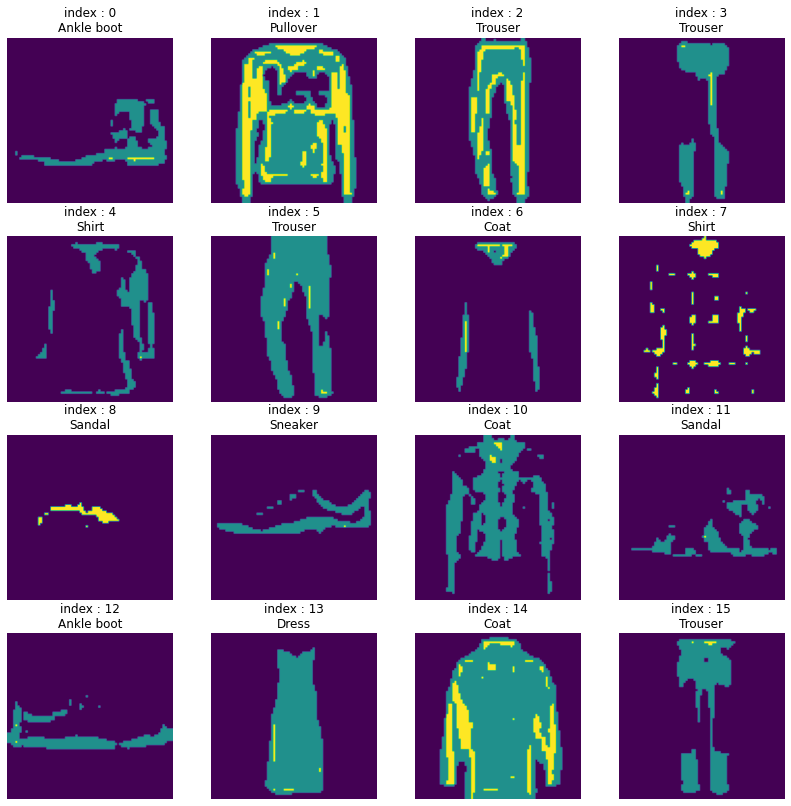

In [18]:
plt.figure(figsize=(14, 14))
images, labels= next(test_images)
img, labels = images.to(device), labels.to(device)
model.eval()
predictions = model(img)
y_pred = torch.argmax(predictions, dim=1).to("cpu")
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(images[i].permute(1,2,0).numpy().reshape((80,80)).astype("uint8"))
  current_index = current_batch*BATCH_SIZE+i
  plt.title(f"index : {current_index}\n{class_names[int(y_pred[current_index:current_index+1])]}")
  plt.axis("off")
current_batch += 1